<a href="https://colab.research.google.com/github/Veebug/Animal-Classifier-project-CNN/blob/main/Animal_Classification_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Animal Identification**

How does a Convolutional Neural Network function ?
CNNs process images as volumes, receiving a color image as a rectangular box where the width and height are measured by the number of pixels associated with each dimension, and the depth is three layers deep for each color (RGB). These layers are called channels. Within each pixel of the image, the intensity of the R, G, or B is expressed by a number. That number is part of three, stacked two-dimensional matrices that make up the image volume and form the initial data that is fed to into the convolutional network. The network then begins to filter the image by grouping squares of pixels together and looking for patterns, performing what is known as a convolution. This process of pattern analysis is the foundation of CNN functions.

We will be making use of Convolution Neural Networks to work on the animal dataset obtained from Kaggle ( https://www.kaggle.com/iamsouravbanerjee/animal-image-dataset-90-different-animals). It contains quite a huge number of animals, around 5,400 images of 90 different species of animals. Because of the challenge of running the entire dataset, we further reduced it to 300 images of 5 different species of animals.

The aim of this project is be able to scan and image and identify what the animal is.

This is something that can be developed further as an app to be used by animal lovers to identify animals in nature trails

In [ ]:
# Importing the necessary libraries that will be used for the project 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import os
import re
import random 
from PIL import Image 
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
from torch.utils.data import (Dataset, DataLoader)  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [ ]:
#Import the libraries
import zipfile
import os
# Unzip the file and find in in temp
zip_ref = zipfile.ZipFile('/content/Animal Classification.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
# file path on your drive
len(os.listdir('/tmp/Animals/animals'))

#Results

5

In [ ]:
# We visualize the data to check on the number of animals and the type as well
animals_list = os.listdir('/tmp/Animals/animals/')
animals_file_list = []

for i in range(len(animals_list)):

  animals_file_list.append(os.listdir(str('/tmp/Animals/animals/' + animals_list[i])))  
  n = len(animals_file_list[i])
  print('There are', n , animals_list[i] , 'images.')

There are 60 wolf images.
There are 60 fox images.
There are 60 tiger images.
There are 60 zebra images.
There are 60 leopard images.


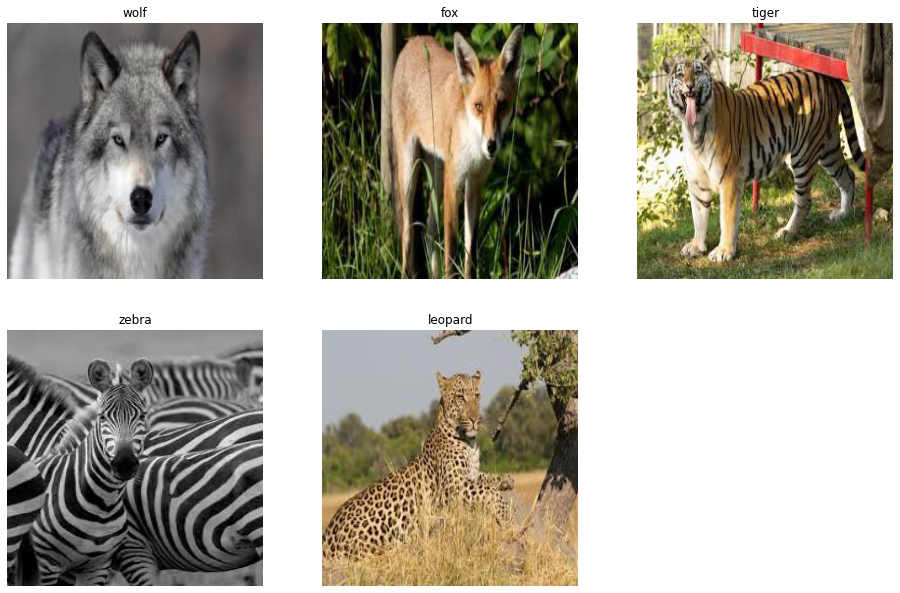

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 3
rows = 3

for i in range(1, len(animals_list)+1):
    img = mpimg.imread(str('/tmp/Animals/animals/'+ animals_list[i-1] + "/"+ animals_file_list[i-1][0]))
    compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256))])
    img = compose(img)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(animals_list[i-1])
    plt.imshow(img)
plt.show()

In [ ]:
# The following are the steps to be followed; 
# We create a dataframe with the name of each file, the animal and the absolute path.
# We select files that will further be in the train, test and validation sets.
# we perform transformation in the data such as reshaping, croping and rotation that
# will allow the images that are from different sizes to be analyzed together.
# we load the datasets using the DataLoader function, that will transform the images in tensors that will be analysed by the CNN.

dir = '/tmp/Animals/animals/'
files = [f for f in glob(dir + "**/**", recursive=True)] # create a list will allabsolute path of all files

In [ ]:
df_animals = pd.DataFrame({"file_path":files}) # transform in a dataframe
df_animals['animal'] = df_animals['file_path'].str.extract('/animals/animals(.+)/') # extract the name of the animal
df_animals['file'] = df_animals['file_path'].str.extract('/animals/animals.+/(.+)') # extrat the file name
df_animals = df_animals.dropna() # drop nas  

In [ ]:
#Now we split the data in train, test and validation
animal_set = set(df_animals['animal'])
train_val_test_list = [0,1,2]
train_val_weights = [70,15,15]
df_animals['train_val_test'] = 'NA' 

for an in animal_set:
  n = sum(df_animals['animal'] == an) # count the number of animals
  train_val_test = random.choices(train_val_test_list, weights= train_val_weights,  k=n)
  df_animals.loc[df_animals['animal'] == an, 'train_val_test'] = train_val_test 

In [ ]:
# We will create the dictonary transform, which will be used to transform the train, test and validation datasets
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}

In [ ]:
#To make sure the data is correctly splited among train, test and validation.
def check_train(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 0).bool

def check_valid(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 1).bool

def check_test(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 2).bool

In [ ]:
#Reading the Dataset 
image_datasets = {
    'train' : ImageFolder(root= dir, transform=transform['train'], is_valid_file=check_train),
    'valid' : ImageFolder(root=dir, transform=transform['valid'], is_valid_file=check_valid),
    'test' : ImageFolder(root=dir, transform=transform['test'], is_valid_file=check_test)
}

In [ ]:
num_workers = 0
batch_size = 5

loaders_scratch = {
    'train' : DataLoader(image_datasets['train'], shuffle = True, batch_size = batch_size),
    'valid' : DataLoader(image_datasets['valid'], shuffle = True, batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'], shuffle = True, batch_size = batch_size)    
}

In [ ]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

**2. Create CNN to classify the Animals**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112 x 112 x 128 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 256 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28 x 28 x 512 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14 x 14 x 512 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        # linear layer (64 * 4 * 4 -> 133)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (133 -> 133)
        self.fc2 = nn.Linear(512, 20)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn5(self.pool(F.relu(self.conv4(x))))
        x = self.conv_bn6(self.pool(F.relu(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6

**We define an optmizer and a loss function.**

**Loss function:** Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0. From the ml-cheatsheet

**Optimizer:** Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the computational burden, achieving faster iterations in trade for a lower convergence rate. From wikipedia

This is preferred as it generalizes better and thus results in improved final performance

In [ ]:
# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)

            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), '/model_scratch.pt')
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/model_scratch.pt'))

Epoch: 1 	Training Loss: 2.533318 	Validation Loss: 2.703612
Validation loss decreased (inf --> 2.703612).  Saving model ...
Epoch: 2 	Training Loss: 1.480345 	Validation Loss: 1.715934
Validation loss decreased (2.703612 --> 1.715934).  Saving model ...
Epoch: 3 	Training Loss: 1.202418 	Validation Loss: 0.877669
Validation loss decreased (1.715934 --> 0.877669).  Saving model ...
Epoch: 4 	Training Loss: 1.124652 	Validation Loss: 0.725371
Validation loss decreased (0.877669 --> 0.725371).  Saving model ...
Epoch: 5 	Training Loss: 0.981311 	Validation Loss: 0.657807
Validation loss decreased (0.725371 --> 0.657807).  Saving model ...
Epoch: 6 	Training Loss: 0.916133 	Validation Loss: 0.583811
Validation loss decreased (0.657807 --> 0.583811).  Saving model ...
Epoch: 7 	Training Loss: 0.891658 	Validation Loss: 0.578910
Validation loss decreased (0.583811 --> 0.578910).  Saving model ...
Epoch: 8 	Training Loss: 0.966865 	Validation Loss: 0.572444
Validation loss decreased (0.57891

<All keys matched successfully>

Test the Model

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    if torch.cuda.is_available():
      model.cuda()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.309923


Test Accuracy: 90% (272/300)


In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    if torch.cuda.is_available():
      model.cuda()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.269131


Test Accuracy: 92% (278/300)


**CNN to Classify Wild Animals (using Transfer Learning)**

The basic premise of transfer learning is that we take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction.
Transfer learning to create a CNN that can identify the animals from the images.

In [ ]:
#Specify data loaders
loaders_transfer = loaders_scratch

In [ ]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# train the model
model_transfer = train(15, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.693913 	Validation Loss: 1.863116
Validation loss decreased (inf --> 1.863116).  Saving model ...
Epoch: 2 	Training Loss: 1.665095 	Validation Loss: 0.599106
Validation loss decreased (1.863116 --> 0.599106).  Saving model ...
Epoch: 3 	Training Loss: 0.865344 	Validation Loss: 0.294750
Validation loss decreased (0.599106 --> 0.294750).  Saving model ...
Epoch: 4 	Training Loss: 0.548696 	Validation Loss: 0.193223
Validation loss decreased (0.294750 --> 0.193223).  Saving model ...
Epoch: 5 	Training Loss: 0.428738 	Validation Loss: 0.145087
Validation loss decreased (0.193223 --> 0.145087).  Saving model ...
Epoch: 6 	Training Loss: 0.396463 	Validation Loss: 0.118121
Validation loss decreased (0.145087 --> 0.118121).  Saving model ...
Epoch: 7 	Training Loss: 0.382710 	Validation Loss: 0.102278
Validation loss decreased (0.118121 --> 0.102278).  Saving model ...
Epoch: 8 	Training Loss: 0.321836 	Validation Loss: 0.089600
Validation loss decreased (0.10227

In [ ]:
model_transfer.load_state_dict(torch.load('/model_scratch.pt'))


<All keys matched successfully>

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.051914


Test Accuracy: 98% (296/300)


In [ ]:
#Write a function that takes a path to an image as input
#and returns the animal that is predicted by the model.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import random
import re

# create a list with a class names
class_names = image_datasets['train'].classes
class_names = [re.sub("\d{3}.", "", item) for item in class_names]
class_names = [re.sub("_", " ", item) for item in class_names]

def predict_breed_transfer(img_path):
  
    # load the image and return the predicted breed    
    img = Image.open(img_path) # Load the image from provided path
    
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize]
    )
    
    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable
    
    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())        
    
    model_transfer.eval()
    output = model_transfer(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    
    # Our prediction will be the index of the class label with the largest value.
    predict_index = output.data.numpy().argmax() 
    
    predicted_breed = class_names[predict_index]
    true_breed = image_datasets['train'].classes[predict_index]
    
    return (predicted_breed, true_breed)

# Create list of test image paths
test_img_paths = list(df_animals[df_animals.train_val_test == 2].file_path)
np.random.shuffle(test_img_paths)

for img_path in test_img_paths[0:5]:
    predicted_breed, true_breed = predict_breed_transfer(img_path)
    print("Predicted Animal:" , predicted_breed, "\n", "True Animal:" , true_breed)
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

Predicted Animal: fox 
 True Animal: fox


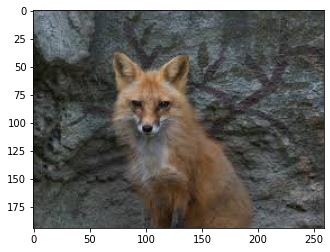

In [ ]:
#Write a function that takes a path to an image as input
#and returns the animal that is predicted by the model.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import random
import re

# create a list with a class names
class_names = image_datasets['train'].classes
class_names = [re.sub("\d{3}.", "", item) for item in class_names]
class_names = [re.sub("_", " ", item) for item in class_names]

def predict_breed_transfer(img_path):
  
    # load the image and return the predicted breed    
    img = Image.open(img_path) # Load the image from provided path
    
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize]
    )
    
    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable
    
    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())        
    
    model_transfer.eval()
    output = model_transfer(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    
    # Our prediction will be the index of the class label with the largest value.
    predict_index = output.data.numpy().argmax() 
    
    predicted_breed = class_names[predict_index]
    true_breed = image_datasets['train'].classes[predict_index]
    
    return (predicted_breed, true_breed)

# Create list of test image paths
test_img_paths = list(df_animals[df_animals.train_val_test == 2].file_path)
np.random.shuffle(test_img_paths)


predicted_breed, true_breed = predict_breed_transfer('/0a9a650a0b.jpg')
print("Predicted Animal:" , predicted_breed, "\n", "True Animal:" , true_breed)
img=mpimg.imread('/0a9a650a0b.jpg')
imgplot = plt.imshow(img)
plt.show()
